In [1]:

import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from scipy.sparse import save_npz

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from IPython.display import display


## 1) Veri Yükleme (Load Data)

`final_clean_data` dosyasını okuyup ilk satırları ve boyutu kontrol ediyoruz.


In [3]:
df = pd.read_csv("final_clean_data.csv")
print("Raw shape:", df.shape)
display(df.head())


Raw shape: (633693, 12)


,rating,title,text,asin,user_id,timestamp,product_title,main_category,average_rating,review_length,year,clean_text
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923,Herbivore - Natural Sea Mist Texturizing Salt ...,All Beauty,4.3,300,2020,spray really nice smells really good goes real...
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.070,All Natural Vegan Dry Shampoo Powder - Eco Fri...,All Beauty,4.0,235,2020,product need wish odorless soft coconut smell ...
2,1.0,Synthetic feeling,Felt synthetic,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220,muaowig Ombre Body Wave Bundles 1B Grey Human ...,All Beauty,1.0,14,2022,felt synthetic
3,5.0,A+,Love it,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.534,Yinhua Electric Nail Drill Kit Portable Profes...,All Beauty,3.5,7,2020,love
4,4.0,Pretty Color,The polish was quiet thick and did not apply s...,B00R8DXL44,AGMJ3EMDVL6OWBJF7CA5RGJLXN5A,2020-08-27 22:30:08.138,"China Glaze Nail Polish, Wanderlust 1381",All Beauty,3.8,125,2020,polish quiet thick apply smoothly let dry over...


## 2) Basit EDA (Exploratory Data Analysis)

Bu bölüm sadece hızlı kontrol içindir:
- Kolonları görürüz.
- Eksik değerleri sayarız.
- Yorum uzunluğu dağılımını inceleriz.

EDA sonuçları raporda kısa bir paragraf ve 1-2 grafikle özetlenebilir.


Columns: ['rating', 'title', 'text', 'asin', 'user_id', 'timestamp', 'product_title', 'main_category', 'average_rating', 'review_length', 'year', 'clean_text']

Missing values:
rating               0
title              141
text               184
asin                 0
user_id              0
timestamp            0
product_title       69
main_category        0
average_rating       0
review_length        0
year                 0
clean_text        1868
dtype: int64

Text length stats:
count    633693.000000
mean        174.201134
std         250.592227
min           0.000000
25%          44.000000
50%         102.000000
75%         210.000000
max       14989.000000
Name: text_length, dtype: float64


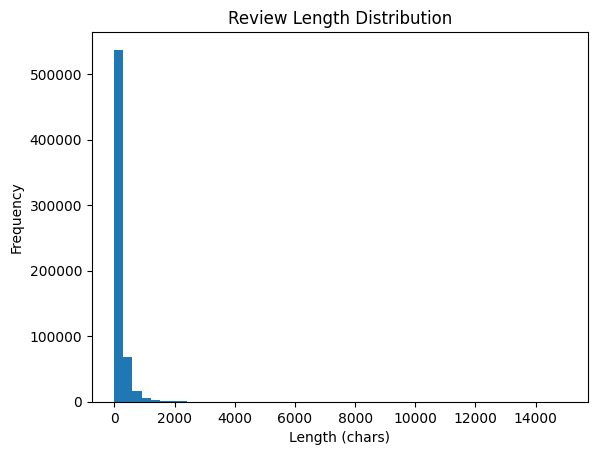

In [4]:
print("Columns:", df.columns.tolist())
print("\nMissing values:")
print(df.isna().sum())

df["text_length"] = df["text"].fillna("").astype(str).str.len()
print("\nText length stats:")
print(df["text_length"].describe())

plt.hist(df["text_length"], bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Length (chars)")
plt.ylabel("Frequency")
plt.show()


## 3) İlk 50.000 Satır ile Çalışma

Grup içinde herkes aynı örneklem büyüklüğünü kullanabilsin diye ilk **50.000** satırı alıyoruz.
Bu, TF‑IDF ve benzerlik matrisleri için ortak bir ürün listesi üretir.


In [5]:
MAX_ROWS = 50000
df = df.head(MAX_ROWS).copy()
print("Working shape:", df.shape)


Working shape: (50000, 13)


## 4) Metin Temizleme (Text Cleaning)

Başlık ve yorumlar için:
- Küçük harf yapma
- URL temizleme
- Noktalama ve özel karakter temizleme
- Boşluk normalizasyonu

CBF'de metin kalitesi direkt benzerlik sonuçlarını etkiler.


In [6]:
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"http\S+|www\S+", " ", s)      
    s = re.sub(r"[^a-z0-9\s]", " ", s)        
    s = re.sub(r"\s+", " ", s).strip()        
    return s

df["title_clean"]  = df["product_title"].fillna("").apply(clean_text)
df["review_clean"] = df["text"].fillna("").apply(clean_text)

display(df[["asin","title_clean","review_clean"]].head())


,asin,title_clean,review_clean
0,B00YQ6X8EO,herbivore natural sea mist texturizing salt sp...,this spray is really nice it smells really goo...
1,B081TJ8YS3,all natural vegan dry shampoo powder eco frien...,this product does what i need it to do i just ...
2,B09JS339BZ,muaowig ombre body wave bundles 1b grey human ...,felt synthetic
3,B08BZ63GMJ,yinhua electric nail drill kit portable profes...,love it
4,B00R8DXL44,china glaze nail polish wanderlust 1381,the polish was quiet thick and did not apply s...


## 5) TF‑IDF Vektörleri (Title + Review)

İki ayrı TF‑IDF matrisi üretiyoruz:
1. **Title TF‑IDF** -> ürün başlığından.
2. **Review TF‑IDF** -> yorum metninden.

Bu matrisler hybrid modelde kullanılacağı için `outputs/` klasörüne kaydedilir.


In [9]:
import os
import joblib
from scipy.sparse import save_npz
from sklearn.feature_extraction.text import TfidfVectorizer

title_vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=5000,
    ngram_range=(1, 2),
    min_df=1
)
X_title_tfidf = title_vectorizer.fit_transform(df["title_clean"].values)
print("Title TF-IDF shape:", X_title_tfidf.shape)

review_vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=10000,
    ngram_range=(1, 2),
    min_df=3
)
X_review_tfidf = review_vectorizer.fit_transform(df["review_clean"].values)
print("Review TF-IDF shape:", X_review_tfidf.shape)

os.makedirs("outputs", exist_ok=True)

save_npz("outputs/X_title_tfidf.npz", X_title_tfidf)
save_npz("outputs/X_review_tfidf.npz", X_review_tfidf)

joblib.dump(title_vectorizer, "outputs/title_vectorizer.pkl")
joblib.dump(review_vectorizer, "outputs/review_vectorizer.pkl")

joblib.dump(X_title_tfidf, "outputs/X_title_tfidf.pkl")
joblib.dump(X_review_tfidf, "outputs/X_review_tfidf.pkl")

print("Saved NPZ + PKL successfully.")


Title TF-IDF shape: (50000, 5000)
Review TF-IDF shape: (50000, 10000)
Saved NPZ + PKL successfully.


## 6) Cosine Similarity ile Top‑K Komşular (CBF)

Tam NxN cosine benzerlik matrisi çok büyük olacağı için:
- `NearestNeighbors` ile sadece her ürünün **Top‑20** benzer ürününü çıkarıyoruz.
- Sonuç iki csv olarak kaydedilir:
  - `cbf_title_top20.csv`
  - `cbf_review_top20.csv`


In [10]:
def compute_topk_neighbors(X, item_ids, k=20, metric="cosine"):
    nn = NearestNeighbors(
        n_neighbors=k+1,      
        metric=metric,
        algorithm="brute",
        n_jobs=-1
    )
    nn.fit(X)
    distances, indices = nn.kneighbors(X, return_distance=True)
    asins = np.array(item_ids)

    rows = []
    for i in range(len(asins)):
        src_asin = asins[i]
        for rank, (idx, dist) in enumerate(
            zip(indices[i][1:], distances[i][1:]), start=1
        ):
            rows.append({
                "source_asin": src_asin,
                "neighbor_asin": asins[idx],
                "rank": rank,
                "similarity": float(1 - dist)
            })
    return pd.DataFrame(rows)

asins = df["asin"].values

topk_title_df = compute_topk_neighbors(X_title_tfidf, asins, k=20)
topk_review_df = compute_topk_neighbors(X_review_tfidf, asins, k=20)

topk_title_df.to_csv("outputs/cbf_title_top20.csv", index=False)
topk_review_df.to_csv("outputs/cbf_review_top20.csv", index=False)

df[["asin"]].to_csv("outputs/asin_list.csv", index=False)

print("CBF outputs saved.")
display(topk_title_df.head())


CBF outputs saved.


,source_asin,neighbor_asin,rank,similarity
0,B00YQ6X8EO,B00YQ6X8EO,1,1.0
1,B00YQ6X8EO,B00YQ6X8EO,2,1.0
2,B00YQ6X8EO,B00YQ6X8EO,3,1.0
3,B00YQ6X8EO,B00YQ6X8EO,4,1.0
4,B00YQ6X8EO,B00YQ6X8EO,5,1.0


---

# Project Outline (Vize) Requirement Part

Ders şartları gereği, her üye:
1. **Feature Selection** uygular.
2. **Dimension Reduction** uygular.
3. En az **2 base model** dener.
4. 4 aşamada performans karşılaştırır.

CBF metin temelli olduğu için burada basit bir sınıflandırma hedefi tanımlıyoruz.


## 7) Basit Target Tanımı

`rating` değerini ikili sınıfa çeviriyoruz:
- `rating >= 4`  -> 1 (iyi)
- `rating < 4`   -> 0 (kötü)

Bu sadece outline karşılaştırması içindir.


In [11]:
if "rating" in df.columns:
    df["label"] = (df["rating"] >= 4).astype(int)
else:
    raise ValueError("final_clean_data.csv")


## 8) Train-Test Split

Review TF‑IDF özelliklerini kullanıp %80 train, %20 test ayırıyoruz.


In [12]:
X = X_review_tfidf  
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## 9) Aşama A: Feature Selection ve DR Öncesi Base Models

İki basit model deneriz:
- Multinomial Naive Bayes
- KNN classifier

Bu sonuçlar "Before_FS_DR" olarak tabloya girer.


In [13]:
results = []

def eval_stage(Xtr, Xte, stage_name):
    models = [
        ("NaiveBayes", MultinomialNB()),
        ("KNN", KNeighborsClassifier(n_neighbors=10))
    ]
    for name, model in models:
        model.fit(Xtr, y_train)
        pred = model.predict(Xte)
        results.append({
            "stage": stage_name,
            "model": name,
            "accuracy": accuracy_score(y_test, pred),
            "f1": f1_score(y_test, pred),
            "precision": precision_score(y_test, pred),
            "recall": recall_score(y_test, pred)
        })

eval_stage(X_train, X_test, "Before_FS_DR")


## 10) Aşama B: Feature Selection (Chi‑Square)

En bilinen metin tabanlı FS yaklaşımlarından biri olan **Chi2** kullanıyoruz.
En yüksek 5000 terimi seçiyoruz.

Bu aşamadan sonra aynı base modelleri tekrar deneriz.


In [14]:
fs = SelectKBest(chi2, k=5000)
X_train_fs = fs.fit_transform(X_train, y_train)
X_test_fs  = fs.transform(X_test)

eval_stage(X_train_fs, X_test_fs, "After_FS(Chi2)")


## 11) Aşama C: Dimension Reduction (TruncatedSVD)

Sparse TF‑IDF üzerinde PCA benzeri çalışan **TruncatedSVD** kullanıyoruz.
5000 terimi daha düşük boyuta (300) indiriyoruz.

Sonra base modelleri yeniden eğitip karşılaştırıyoruz.


In [18]:
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_dr = svd.fit_transform(X_train_fs)
X_test_dr  = svd.transform(X_test_fs)
eval_stage(X_train_dr, X_test_dr, "After_FS_DR(SVD)")

from sklearn.linear_model import LogisticRegression

def eval_stage(Xtr, Xte, stage_name):
    if "DR" not in stage_name:
        models = [
            ("NaiveBayes", MultinomialNB()),
            ("KNN", KNeighborsClassifier(n_neighbors=10))
        ]
    else:
        models = [
            ("LogReg", LogisticRegression(max_iter=1000)),
            ("KNN", KNeighborsClassifier(n_neighbors=10))
        ]
        
    for name, model in models:
        model.fit(Xtr, y_train)
        pred = model.predict(Xte)
        results.append({
            "stage": stage_name,
            "model": name,
            "accuracy": accuracy_score(y_test, pred),
            "f1": f1_score(y_test, pred),
            "precision": precision_score(y_test, pred),
            "recall": recall_score(y_test, pred)
        })


## 12) Sonuç Tablosu ve Kaydetme

Her aşamadaki iki modelin metriklerini tek bir tabloda topluyoruz.
Bu tablo raporda "Üye Bazlı Base Model Performansları" kısmına konur.


In [19]:
results_df = pd.DataFrame(results)
print("\n=== BASE MODEL COMPARISON TABLE ===")
display(results_df)

results_df.to_csv("outputs/elisa_base_models_comparison.csv", index=False)
print("Saved: outputs/elisa_base_models_comparison.csv")



=== BASE MODEL COMPARISON TABLE ===


,stage,model,accuracy,f1,precision,recall
0,Before_FS_DR,NaiveBayes,0.8437,0.901382,0.841343,0.970648
1,Before_FS_DR,KNN,0.7435,0.844215,0.763233,0.944422
2,After_FS(Chi2),NaiveBayes,0.8441,0.901795,0.840535,0.972687
3,After_FS(Chi2),KNN,0.7618,0.850283,0.791019,0.919147
4,After_FS_DR(SVD),LogReg,0.8466,0.900892,0.858726,0.947411
5,After_FS_DR(SVD),KNN,0.7728,0.844554,0.850489,0.838701


Saved: outputs/elisa_base_models_comparison.csv


# Kısa Yorum (Rapora Yazılacak)

- Chi2 FS sonrası performans artışı beklenir çünkü gürültülü kelimeler elenir.
- TruncatedSVD sonrası boyut düşer, bazı modellerin genellemesi iyileşebilir veya bilgi kaybı yüzünden düşebilir.
- En iyi aşama ve modeli tabloya bakarak seçip nedenlerini 3-4 cümle ile tartışınız.


In [ ]:
Elisa Demır 22040301152 kod dosyasi

Content-Based Filtering (TF-IDF Title), 
Content-Based Filtering (TF-IDF Review 
Text), cosine similarity computation 

Genel Açıklama – Projede Neler Yaptım?

Bu projede metin verileriyle çalışan bir öneri ve sınıflandırma sistemi geliştirildi. Veri olarak kullanıcı yorumları, ürün başlıkları ve ürün puanları kullanıldı. Proje kapsamında dersin istediği şekilde üç ana adım uygulandı: Feature Selection (Özellik Seçimi), Dimension Reduction (Boyut İndirgeme) ve Base Model karşılaştırması.

1. Hedef Değişkenin Oluşturulması

Rating sayısal bir değer olduğu için ikili sınıfa çevrildi:

4 ve üzeri puanlar iyi (1)

4’ten düşük puanlar kötü (0)

Bu sayede yorumların olumlu mu olumsuz mu olduğu tahmin edilmeye çalışıldı.

2. Eğitim-Test Ayrımı

TF-IDF ile üretilen özellikler %80 eğitim, %20 test olacak şekilde ayrıldı.
Böylece modellerin gerçek performansı ölçülebildi.

3. Aşama A: Base Modeller (FS/DR Öncesi)

İlk olarak 2 temel model denendi:

Naive Bayes ve KNN Sonuçlara göre Naive Bayes daha iyi çalıştı.
Bu beklenen bir durumdur çünkü Naive Bayes genellikle metin verilerinde güçlü bir modeldir.

4. Aşama B: Feature Selection (Chi-Square)

Chi2 yöntemiyle en anlamlı 5000 kelime seçildi.
Bu işlem gürültüyü azalttığı için bazı modellerde performans artışı sağladı.

Özellikle Naive Bayes modelinde küçük bir iyileşme görüldü.

5. Aşama C: Dimension Reduction (SVD)

Chi2 ile seçilen 5000 özellik, TruncatedSVD yöntemiyle 300 boyuta indirildi.
Bu boyut indirgeme işlemi sonrası Logistic Regression modeli en yüksek başarıyı verdi.

Bu sonuç, düşük boyutlu ve yoğun matrislerde Logistic Regression’ın iyi çalışmasıyla uyumludur.

6. Genel Değerlendirme

Chi2 ile özellik seçimi, metin verisindeki gereksiz kelimeleri kaldırdığı için performansı artırdı.

SVD ile boyut indirgeme sonrası Logistic Regression en iyi modeli verdi.

KNN modeli her aşamada daha düşük performans gösterdi. Bunun nedeni KNN’in yüksek boyutlu TF-IDF matrislerinde zorlanmasıdır.

7. Sonuç

Yapılan FS ve DR adımları modellerin performansını geliştirdi ve hangi tekniklerin metin verisinde daha faydalı olduğu görüldü.
En başarılı yöntem SVD + Logistic Regression kombinasyonu olmuştur.